# CLIMADA - RIM2D data flow: EXAMPLE 1

Coordinate system: crs 4647 

In this notebook we show one simple impact calculations with CLIMADA using a datafile for floods from the PIK model.

In [1]:
from pathlib import Path

**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [2]:
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

### Read the data

In [3]:
# Define the file path
haz_folder = 'RIM2D'
haz_path = data_path / haz_folder
haz_file = 'mysimulation_wd_max.asc'

#haz_file = 'HouseGrid.asc'

file_path = haz_path / haz_file

In [4]:
# import rioxarray

# data = rioxarray.open_rasterio(file_path)

In [5]:
# data

In [6]:
import numpy as np

# Function to read the .asc file and extract header and data
def read_asc_file(file_path):
    with open(file_path, 'r') as file:
        # Read the header
        header = {}
        header['ncols'] = int(file.readline().split()[1])
        header['nrows'] = int(file.readline().split()[1])
        header['xllcorner'] = float(file.readline().split()[1])
        header['yllcorner'] = float(file.readline().split()[1])
        header['cellsize'] = float(file.readline().split()[1])
        header['nodata_value'] = float(file.readline().split()[1])
        
        # Read the data
        data = np.loadtxt(file, skiprows=0)
        
    return header, data

# Read the .asc file
header, data = read_asc_file(file_path)

# Print header information
print("Header Information:")
print(f"ncols: {header['ncols']}, nrows: {header['nrows']}")
print(f"xllcorner: {header['xllcorner']}, yllcorner: {header['yllcorner']}")
print(f"cellsize: {header['cellsize']}, nodata_value: {header['nodata_value']}")

# Print data shape
print("Data shape:", data.shape)

# Example of accessing the data
print("First 5 rows of data:")
print(data[:5])

Header Information:
ncols: 4121, nrows: 1350
xllcorner: 32357389.3134, yllcorner: 5596180.6247
cellsize: 5.0, nodata_value: -9999.0
Data shape: (1350, 4121)
First 5 rows of data:
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.024 0.02  0.   ]
 [0.    0.    0.    ... 0.011 0.035 0.001]
 [0.    0.    0.    ... 0.    0.058 0.011]
 [0.    0.    0.    ... 0.    0.072 0.033]]


#### Plot the data

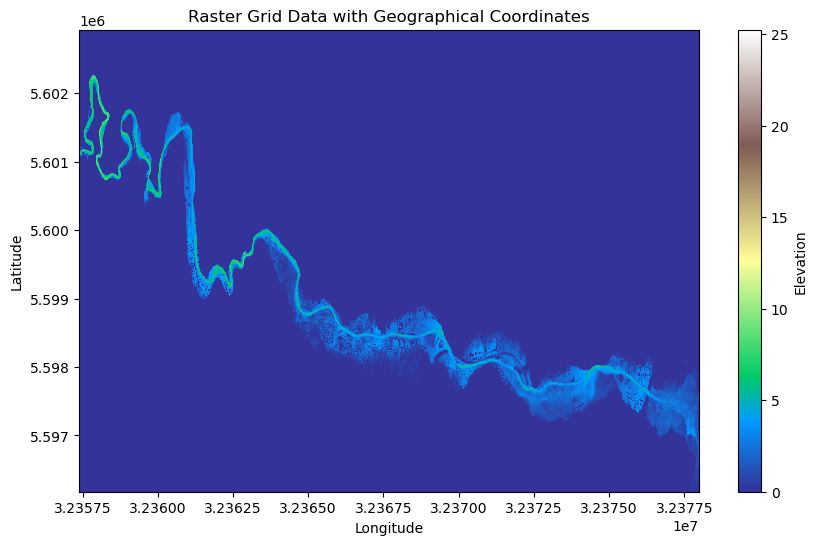

In [7]:
import matplotlib.pyplot as plt


# Mask the no-data values
#data = np.ma.masked_equal(data, header['nodata_value'])

# Create coordinate arrays
nrows, ncols = data.shape
x_coords = np.linspace(header['xllcorner'], header['xllcorner'] + (ncols - 1) * header['cellsize'], ncols)
y_coords = np.linspace(header['yllcorner'], header['yllcorner'] + (nrows - 1) * header['cellsize'], nrows)

# Create meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

# Plot the data with geographical coordinates
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Y, data, cmap='terrain', shading='auto')
plt.colorbar(label='Elevation')
plt.title('Raster Grid Data with Geographical Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Define hazards

### Define hazard Manually

In [8]:
# from pyproj import CRS, Transformer

# # Initialize the transformer to convert from CRS 4647 to WGS84
# crs_proj = CRS.from_epsg(4647)  # Hong Kong 1980 Grid System
# crs_wgs84 = CRS.from_epsg(4326)  # WGS84 Latitude/Longitude
# transformer = Transformer.from_crs(crs_proj, crs_wgs84, always_xy=True)

# # Convert all points in the grid
# lon, lat = transformer.transform(X, Y)

# # Flatten the arrays if needed for further processing
# lon_flat = lon.flatten()
# lat_flat = lat.flatten()

In [9]:
data

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.024, 0.02 , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.011, 0.035, 0.001],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

### Centroids

In [10]:
from scipy.sparse import csr_matrix
from climada.hazard import Hazard, Centroids

# Convert meshgrid to 1D arrays for lat and lon
lon = X.flatten() # longitude
lat = Y.flatten() # latitude
values = data.flatten() # intensity of the event

# Trasform the values to default units

intensity = csr_matrix(values.reshape(1, -1)) # intensity of the event
n_ev = 1 # number of events
crs =  f'EPSG:{4647}' # Coordinate Reference System
frequency= np.ones(n_ev)/1000 # Abritrary frequency of the event
units='m' # units of the intensity

haz = Hazard(haz_type='RF',
             intensity=intensity,
            centroids = Centroids(lat=lat, lon=lon, crs=crs),  
            units='m',
            event_id=np.arange(n_ev, dtype=int),
            frequency=frequency
            )

haz.check()


<GeoAxes: title={'center': 'RF max intensity at each point'}>

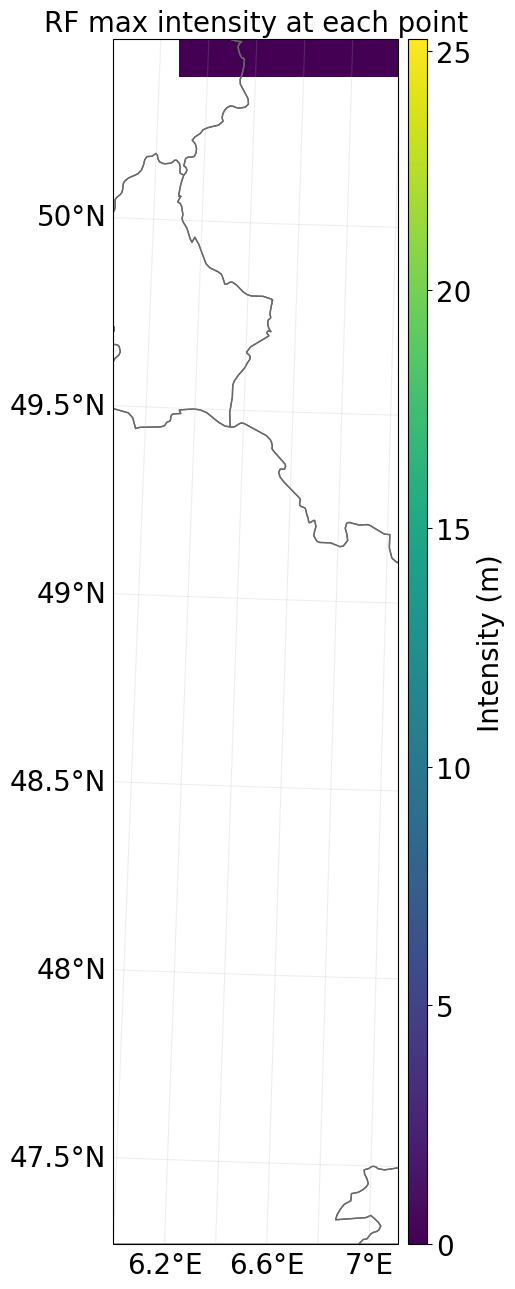

In [12]:
haz.plot_intensity(event=0)